In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime  # Importa datetime
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score

# Modelo ML para determinar variacion de stock migratorio con cambios en los indicadores 

A partir del dataset de stock migratorio de las naciones unidas y los valores de indicadores del banco mundial se contruyo una tabla para el entrenamiento del modelo.
Para obtener el dataset de trabajo se realizaron las siguientes transformaciones:
* se agrupo el dataset de naciones unidas por pais de destino, sumando las cantidades de todos los paises de origen,   
  obteniendo el valor de stock de inmigrantes por pais por año
* se agregaron a la tabla los valores de los indicadores del banco mundial.
Todo este analisis para llegar al datset esta en el notebook 'EDA_datasets_internacionales'.

### 1. Ingesta de dataset con datos para entrenamiento del modelo

In [12]:
Stock_migrantes_agrupado=pd.read_csv('Stock_migrantes_agrupado')

In [13]:
Stock_migrantes_agrupado=Stock_migrantes_agrupado.drop(columns='Unnamed: 0')

In [14]:
Stock_migrantes_agrupado.head(3)

,ISO3_dest,Year,ingreso_stock,Country Code,Ingresos,Electricidad,Contaminación,Crecimiento PBI,Crecimiento PBI per cápita,Desempleo Hombre,Desempleo mujeres,Gasto PBI,Importaciones,Migracion neta,Desempleados con educación avanzada,Tasa de cambio,Pobreza,Mortalidad
0,ABW,1990,11099,ABW,NaN,100.000000,NaN,3.961402,2.195805,NaN,NaN,NaN,5.810000e+08,879.0,NaN,1.79,NaN,7.100
1,ABW,1995,19002,ABW,NaN,100.000000,NaN,2.547144,-0.567202,NaN,NaN,NaN,1.597000e+09,1598.0,NaN,1.79,NaN,6.366
2,ABW,2000,26897,ABW,NaN,91.660398,NaN,7.616589,4.918354,6.5,NaN,NaN,2.582000e+09,1235.0,NaN,1.79,NaN,6.335


#### 1.a Elimino filas que tengan menos valores no nulos que el umbral

In [15]:
umbral = len(Stock_migrantes_agrupado.columns) * 0.7
Stock_migrantes_agrupado_sin_na= Stock_migrantes_agrupado.dropna(thresh=umbral)

In [17]:
Stock_migrantes_agrupado_sin_na.shape

(1039, 18)

#### 1.b Imputo datos faltantes en las columnas remanentes con KNN

In [16]:
# columnas a imputar son las siguientes
columns_to_impute = ['ingreso_stock', 'Ingresos',
       'Electricidad', 'Contaminación', 'Crecimiento PBI',
       'Crecimiento PBI per cápita', 'Desempleo Hombre', 'Desempleo mujeres',
       'Gasto PBI', 'Importaciones',
       'Desempleados con educación avanzada', 'Tasa de cambio', 'Pobreza',
       'Mortalidad']

# Copiar el DataFrame original para no modificarlo directamente
Stock_migrantes_agrupado_sin_na_imputed =Stock_migrantes_agrupado_sin_na.copy()

# Crear una instancia de KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Elige el número de vecinos que deseas considerar

# Ajustar y transformar los datos utilizando KNNImputer
Stock_migrantes_agrupado_sin_na_imputed[columns_to_impute] = imputer.fit_transform(Stock_migrantes_agrupado_sin_na_imputed[columns_to_impute])

In [18]:
# Ordenar el DataFrame por la columna 'Year'
Stock_migrantes_agrupado_sin_na_imputed.sort_values('Year', inplace=True)

# Restablecer el índice
Stock_migrantes_agrupado_sin_na_imputed.reset_index(drop=True, inplace=True)

In [19]:
Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock']=Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock'].astype(int)

In [23]:
Stock_migrantes_agrupado_sin_na_imputed.columns

Index(['ISO3_dest', 'Year', 'ingreso_stock', 'Country Code', 'Ingresos',
       'Electricidad', 'Contaminación', 'Crecimiento PBI',
       'Crecimiento PBI per cápita', 'Desempleo Hombre', 'Desempleo mujeres',
       'Gasto PBI', 'Importaciones', 'Migracion neta',
       'Desempleados con educación avanzada', 'Tasa de cambio', 'Pobreza',
       'Mortalidad'],
      dtype='object')

#### 2. Modelo XGBRegressor con optimizacion de hiperparametros utilizando OPTUNA

In [24]:
import optuna
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Definir features y target
X = Stock_migrantes_agrupado_sin_na_imputed.drop(['ingreso_stock','Migracion neta','Country Code','Tasa de cambio','Desempleo mujeres','Desempleo Hombre','Contaminación','Crecimiento PBI','Gasto PBI'], axis=1)  # Características excepto 'Migracion neta' y 'Country Code'
y = Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock']  # Etiquetas



# Dividir los datos en conjuntos de entrenamiento y prueba y hacer dummies
X = pd.get_dummies(X, columns=['ISO3_dest'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Definir la función de objetivo para la optimización de Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }
    
    xgb_model = XGBRegressor(**param)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_xgb_model = XGBRegressor(**best_params)
best_model = final_xgb_model.fit(X_train, y_train)
y_pred = final_xgb_model.predict(X_test)

# Calcular el MAE con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados



# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("MAE con los mejores hiperparámetros:", mae_final)
print("R-squared (R2):", r2)


[I 2023-11-13 14:30:04,184] A new study created in memory with name: no-name-85743cfc-df67-45e6-b5ab-e8443dc97cc6
[I 2023-11-13 14:30:06,083] Trial 0 finished with value: 445058.2348761925 and parameters: {'n_estimators': 777, 'max_depth': 7, 'learning_rate': 0.2938958087647873}. Best is trial 0 with value: 445058.2348761925.
[I 2023-11-13 14:30:06,821] Trial 1 finished with value: 560021.8905053505 and parameters: {'n_estimators': 257, 'max_depth': 10, 'learning_rate': 0.07354762221268094}. Best is trial 0 with value: 445058.2348761925.
[I 2023-11-13 14:30:08,246] Trial 2 finished with value: 511170.7102860671 and parameters: {'n_estimators': 499, 'max_depth': 10, 'learning_rate': 0.29732363826167935}. Best is trial 0 with value: 445058.2348761925.
[I 2023-11-13 14:30:10,597] Trial 3 finished with value: 526115.6352497614 and parameters: {'n_estimators': 928, 'max_depth': 9, 'learning_rate': 0.05529110856658858}. Best is trial 0 with value: 445058.2348761925.
[I 2023-11-13 14:30:11,59

Mejores hiperparámetros: {'n_estimators': 964, 'max_depth': 3, 'learning_rate': 0.1522420975767905}
MAE con los mejores hiperparámetros: 333407.2245724018


#### 2.1 Evaluacion de Modelo

In [59]:
# Calcular el MAE con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [61]:
mae_final

333407.2245724018

In [45]:
results_df = pd.DataFrame({'Y_test': y_test, 'Y_pred': y_pred})

In [62]:
r2

0.9708864245148827

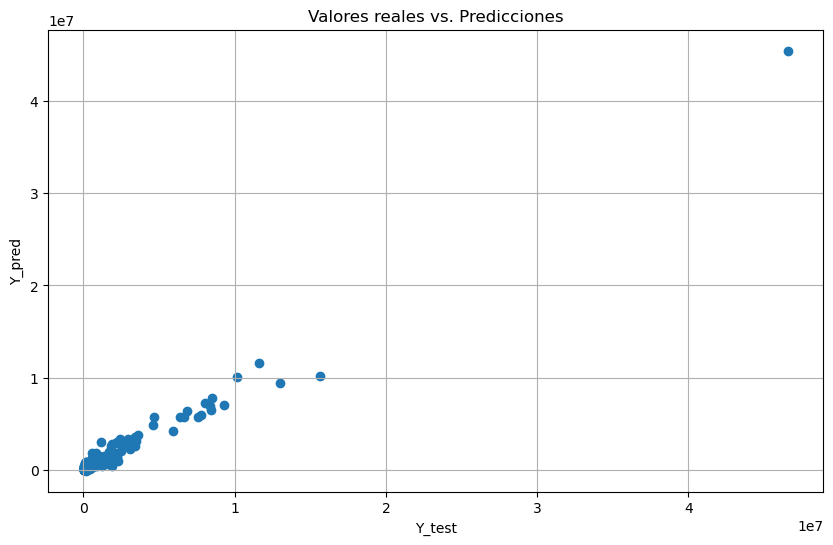

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Y_test'], results_df['Y_pred'])
plt.xlabel('Y_test')
plt.ylabel('Y_pred')
plt.title('Valores reales vs. Predicciones')
plt.grid(True)
plt.show()

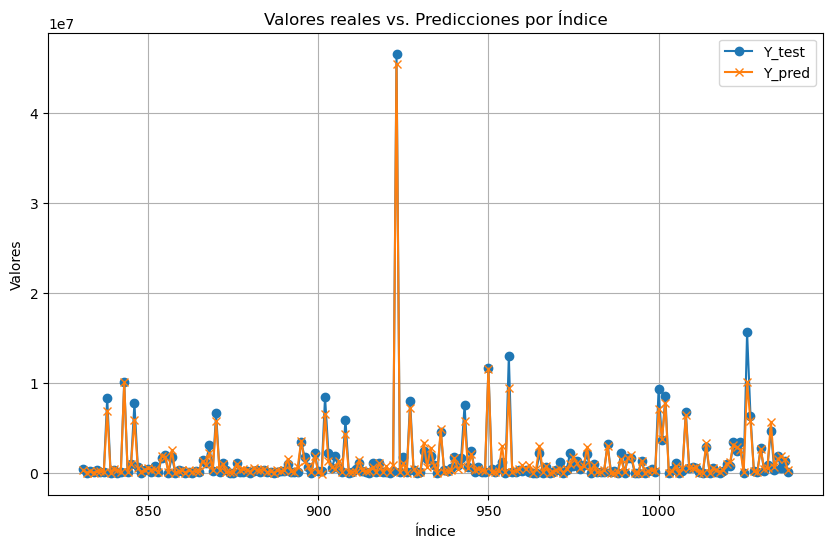

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Y_test'], label='Y_test', marker='o')
plt.plot(results_df.index, results_df['Y_pred'], label='Y_pred', marker='x')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores reales vs. Predicciones por Índice')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
Stock_migrantes_agrupado_sin_na_imputed[Stock_migrantes_agrupado_sin_na_imputed['ISO3_dest']=='ARG'].describe()

,Year,ingreso_stock,Ingresos,Electricidad,Contaminación,Crecimiento PBI,Crecimiento PBI per cápita,Desempleo Hombre,Desempleo mujeres,Gasto PBI,Importaciones,Migracion neta,Desempleados con educación avanzada,Tasa de cambio,Pobreza,Mortalidad
count,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000
mean,2005.000000,1.742792e+06,25.447429,96.700577,99.363727,0.809080,-0.215344,11.215429,13.729800,18.984028,3.391329e+10,-7935.714286,13.892286,12.722735,26.577143,7.716286
std,10.801234,2.931433e+05,9.747666,3.006352,0.614866,7.040660,7.206073,3.653417,4.599305,5.417736,2.029147e+10,13205.928905,9.027883,25.670341,8.905470,0.363913
min,1990.000000,1.459713e+06,5.516000,92.154800,98.021929,-9.943235,-10.812611,6.650000,8.645000,10.325440,4.076000e+09,-22770.000000,3.050000,0.487589,18.080000,7.423000
25%,1997.500000,1.538965e+06,24.518000,94.757469,99.429573,-2.656212,-3.997135,8.565000,10.802000,16.172060,2.263800e+10,-20848.500000,4.870000,0.999625,19.590000,7.539000
50%,2005.000000,1.614915e+06,27.776000,96.725266,99.549971,-0.788999,-1.906987,10.750000,13.600000,19.678151,2.868900e+10,-4970.000000,21.114000,2.903658,23.180000,7.600000
75%,2012.500000,1.904917e+06,30.262000,99.254517,99.593832,5.791410,4.681081,13.739000,15.023800,22.343272,4.957350e+10,3933.000000,21.114000,6.564740,31.800000,7.702000
max,2020.000000,2.237152e+06,35.280000,100.000000,99.927378,10.125398,9.844296,16.500000,22.212000,25.853943,6.020500e+10,6021.000000,21.114000,70.539167,42.000000,8.509000


In [48]:
Stock_migrantes_agrupado_sin_na_imputed[Stock_migrantes_agrupado_sin_na_imputed['ISO3_dest']=='ARG']

,ISO3_dest,Year,ingreso_stock,Country Code,Ingresos,Electricidad,Contaminación,Crecimiento PBI,Crecimiento PBI per cápita,Desempleo Hombre,Desempleo mujeres,Gasto PBI,Importaciones,Migracion neta,Desempleados con educación avanzada,Tasa de cambio,Pobreza,Mortalidad
37,ARG,1990,1565392,ARG,5.516,92.154800,99.606700,-2.467214,-3.877390,7.130,13.6886,10.325440,4.076000e+09,6021.0,21.114,0.487589,31.82,7.743
161,ARG,1995,1512538,ARG,35.280,93.834465,99.580965,-2.845210,-4.116881,16.500,22.2120,15.511231,2.012200e+10,-19736.0,21.114,0.999750,18.58,7.535
242,ARG,2000,1459713,ARG,27.708,95.680473,99.549971,-0.788999,-1.906987,14.050,16.3590,16.832888,2.515400e+10,-22770.0,21.114,0.999500,31.78,7.600
494,ARG,2005,1614915,ARG,21.328,96.725266,99.411504,8.851660,7.732497,10.000,13.6000,19.678151,2.868900e+10,-21961.0,5.020,2.903658,23.18,7.423
573,ARG,2010,1767689,ARG,29.190,98.820000,99.447641,10.125398,9.844296,6.650,9.2140,19.678151,5.679300e+10,-4970.0,3.050,3.896295,18.08,7.661
855,ARG,2015,2042145,ARG,27.776,99.689034,98.021929,2.731160,1.629664,13.428,8.6450,25.008393,6.020500e+10,5522.0,21.114,9.233186,20.60,7.543
899,ARG,2020,2237152,ARG,31.334,100.000000,99.927378,-9.943235,-10.812611,10.750,12.3900,25.853943,4.235400e+10,2344.0,4.720,70.539167,42.00,8.509


In [49]:
results_df_con_pais = pd.DataFrame({'Y_test': y_test, 'Y_pred': y_pred, 'Pais': X_test['ISO3_dest_ARG'],'Año': X_test['Year'] })

# Filtrar los resultados para un país específico
pais_seleccionado = 1  # Reemplaza con el nombre de tu país de interés
results_arg = results_df_con_pais[results_df_con_pais['Pais'] == pais_seleccionado]

In [50]:
results_arg

,Y_test,Y_pred,Pais,Año
855,2042145,1832436.25,1,2015
899,2237152,1851345.75,1,2020


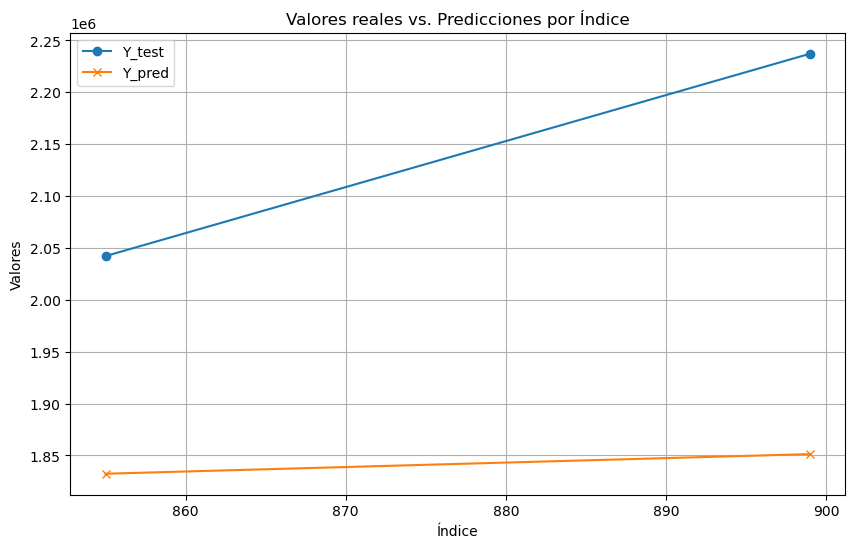

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(results_arg.index, results_arg['Y_test'], label='Y_test', marker='o')
plt.plot(results_arg.index, results_arg['Y_pred'], label='Y_pred', marker='x')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores reales vs. Predicciones por Índice')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
best_model.save_model('xgb_model_final_1.json')

In [53]:
X.columns

Index(['Year', 'Ingresos', 'Electricidad', 'Crecimiento PBI per cápita',
       'Importaciones', 'Desempleados con educación avanzada', 'Pobreza',
       'Mortalidad', 'ISO3_dest_AFG', 'ISO3_dest_AGO',
       ...
       'ISO3_dest_UZB', 'ISO3_dest_VCT', 'ISO3_dest_VEN', 'ISO3_dest_VNM',
       'ISO3_dest_VUT', 'ISO3_dest_WSM', 'ISO3_dest_YEM', 'ISO3_dest_ZAF',
       'ISO3_dest_ZMB', 'ISO3_dest_ZWE'],
      dtype='object', length=199)

In [54]:
X.shape

(1039, 199)

In [55]:
columnas=X_train.columns
df = pd.DataFrame([0]*len(columnas), index=columnas).T
df.to_csv('para_llenar_2')

In [56]:
df

,Year,Ingresos,Electricidad,Crecimiento PBI per cápita,Importaciones,Desempleados con educación avanzada,Pobreza,Mortalidad,ISO3_dest_AFG,ISO3_dest_AGO,ISO3_dest_ALB,ISO3_dest_ARE,ISO3_dest_ARG,ISO3_dest_ARM,ISO3_dest_AUS,ISO3_dest_AUT,ISO3_dest_AZE,ISO3_dest_BDI,ISO3_dest_BEL,ISO3_dest_BEN,ISO3_dest_BFA,ISO3_dest_BGD,ISO3_dest_BGR,ISO3_dest_BHR,ISO3_dest_BHS,ISO3_dest_BIH,ISO3_dest_BLR,ISO3_dest_BLZ,ISO3_dest_BMU,ISO3_dest_BOL,ISO3_dest_BRA,ISO3_dest_BRB,ISO3_dest_BRN,ISO3_dest_BTN,ISO3_dest_BWA,ISO3_dest_CAF,ISO3_dest_CAN,ISO3_dest_CHE,ISO3_dest_CHL,ISO3_dest_CHN,ISO3_dest_CIV,ISO3_dest_CMR,ISO3_dest_COD,ISO3_dest_COG,ISO3_dest_COL,ISO3_dest_COM,ISO3_dest_CPV,ISO3_dest_CRI,ISO3_dest_CUB,ISO3_dest_CUW,ISO3_dest_CYM,ISO3_dest_CYP,ISO3_dest_CZE,ISO3_dest_DEU,ISO3_dest_DJI,ISO3_dest_DNK,ISO3_dest_DOM,ISO3_dest_DZA,ISO3_dest_ECU,ISO3_dest_EGY,ISO3_dest_ERI,ISO3_dest_ESP,ISO3_dest_EST,ISO3_dest_ETH,ISO3_dest_FIN,ISO3_dest_FJI,ISO3_dest_FRA,ISO3_dest_FSM,ISO3_dest_GAB,ISO3_dest_GBR,ISO3_dest_GEO,ISO3_dest_GHA,ISO3_dest_GIN,ISO3_dest_GMB,ISO3_dest_GNB,ISO3_dest_GNQ,ISO3_dest_GRC,ISO3_dest_GRL,ISO3_dest_GTM,ISO3_dest_GUM,ISO3_dest_GUY,ISO3_dest_HKG,ISO3_dest_HND,ISO3_dest_HRV,ISO3_dest_HTI,ISO3_dest_HUN,ISO3_dest_IDN,ISO3_dest_IND,ISO3_dest_IRL,ISO3_dest_IRN,ISO3_dest_IRQ,ISO3_dest_ISL,ISO3_dest_ISR,ISO3_dest_ITA,ISO3_dest_JAM,ISO3_dest_JOR,ISO3_dest_JPN,ISO3_dest_KAZ,ISO3_dest_KEN,ISO3_dest_KGZ,ISO3_dest_KHM,ISO3_dest_KIR,ISO3_dest_KOR,ISO3_dest_KWT,ISO3_dest_LAO,ISO3_dest_LBN,ISO3_dest_LBR,ISO3_dest_LBY,ISO3_dest_LCA,ISO3_dest_LKA,ISO3_dest_LSO,ISO3_dest_LTU,ISO3_dest_LUX,ISO3_dest_LVA,ISO3_dest_MAC,ISO3_dest_MAR,ISO3_dest_MDA,ISO3_dest_MDG,ISO3_dest_MDV,ISO3_dest_MEX,ISO3_dest_MHL,ISO3_dest_MKD,ISO3_dest_MLI,ISO3_dest_MLT,ISO3_dest_MMR,ISO3_dest_MNE,ISO3_dest_MNG,ISO3_dest_MOZ,ISO3_dest_MRT,ISO3_dest_MUS,ISO3_dest_MWI,ISO3_dest_MYS,ISO3_dest_NAM,ISO3_dest_NCL,ISO3_dest_NER,ISO3_dest_NGA,ISO3_dest_NIC,ISO3_dest_NLD,ISO3_dest_NOR,ISO3_dest_NPL,ISO3_dest_NZL,ISO3_dest_OMN,ISO3_dest_PAK,ISO3_dest_PAN,ISO3_dest_PER,ISO3_dest_PHL,ISO3_dest_PLW,ISO3_dest_PNG,ISO3_dest_POL,ISO3_dest_PRI,ISO3_dest_PRT,ISO3_dest_PRY,ISO3_dest_PSE,ISO3_dest_QAT,ISO3_dest_ROU,ISO3_dest_RUS,ISO3_dest_RWA,ISO3_dest_SAU,ISO3_dest_SDN,ISO3_dest_SEN,ISO3_dest_SGP,ISO3_dest_SLB,ISO3_dest_SLE,ISO3_dest_SLV,ISO3_dest_SMR,ISO3_dest_SRB,ISO3_dest_STP,ISO3_dest_SUR,ISO3_dest_SVK,ISO3_dest_SVN,ISO3_dest_SWE,ISO3_dest_SWZ,ISO3_dest_SYC,ISO3_dest_SYR,ISO3_dest_TCD,ISO3_dest_TGO,ISO3_dest_THA,ISO3_dest_TJK,ISO3_dest_TKM,ISO3_dest_TLS,ISO3_dest_TON,ISO3_dest_TTO,ISO3_dest_TUN,ISO3_dest_TUR,ISO3_dest_TZA,ISO3_dest_UGA,ISO3_dest_UKR,ISO3_dest_URY,ISO3_dest_USA,ISO3_dest_UZB,ISO3_dest_VCT,ISO3_dest_VEN,ISO3_dest_VNM,ISO3_dest_VUT,ISO3_dest_WSM,ISO3_dest_YEM,ISO3_dest_ZAF,ISO3_dest_ZMB,ISO3_dest_ZWE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
